In [9]:
import pandas as pd
import pyarrow.parquet as pq
import pickle
import warnings
import math
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
pd.options.display.max_rows = 2000

### Creating all_data, sp_map, tpls, week_dfs, week_sp_dfs DataFrames

In [2]:
import os

folder_path = '../data/raw gps points/google-oauth2_109244383376429682325'

# List all Parquet files in the folder
parquet_files = [f for f in os.listdir(folder_path) if f.endswith('.parquet')]

# Initialize an empty DataFrame to hold all the data
all_data = pd.DataFrame()

# Loop through the files and read each one into a DataFrame
for file in parquet_files:
    file_path = os.path.join(folder_path, file)
    table = pq.read_table(file_path)
    df = table.to_pandas()

    # Convert the 't' column from Unix to datetime
    df['t'] = pd.to_datetime(df['t'])

    # Append this DataFrame to the main DataFrame
    all_data = pd.concat([all_data, df], ignore_index=True)

# all_data now contains all the data from the Parquet files in the folder

In [55]:
all_data.shape

(77862, 12)

##### all_data a DataFrame With every Point

In [32]:
import trackintel as ti
import geopandas as gpd
from shapely.geometry import Point
import warnings

# Suppress specific UserWarning
warnings.filterwarnings('ignore', category=UserWarning, message='The CRS of your data is not defined.')
warnings.filterwarnings('ignore', message='The positionfixes with ids [.*] lead to invalid tripleg geometries.')

all_data['user_id'] = 1
all_data = all_data[['user_id','t','latitude', 'longitude', 'altitude','accuracy']]
all_data.columns = ['user_id', 'tracked_at', 'latitude', 'longitude', 'elevation', 'accuracy']
all_data['tracked_at'] = all_data['tracked_at'].dt.tz_localize('UTC')

# Assuming 'latitude' and 'longitude' are your coordinate columns
all_data['geometry'] = all_data.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
gall_data = gpd.GeoDataFrame(all_data, geometry='geometry')

all_data.drop_duplicates(inplace=True)

In [57]:
all_data.shape

(77854, 7)

In [58]:
all_data.to_pickle("../data/processed/all_data.pkl")

##### Parameters in generate_staypoint.  
 - distance_metric='haversine': This parameter specifies the method to be used for distance calculation. The default 'haversine' method calculates the distance between two points on the Earth's surface, assuming a spherical Earth.
- 
dist_threshold=100: This is the distance threshold in meters. Position fixes within this distance from each other are considered to be in the same staypoint. In this case, the default value is set to 100 meters.
-
time_threshold=5.0: This is the time threshold in minutes. A group of position fixes needs to be within the distance threshold for at least this duration to be considered a staypoint. The default value here is 5 minutes.
-
gap_threshold=15.0: This parameter, also in minutes, defines the maximum allowed temporal gap between consecutive position fixes within a staypoint. If the gap is larger than this threshold, the staypoint is split. The default value is set to 15 minutes.

In [120]:
pfs = ti.Positionfixes(all_data)
# Now pfs is a Trackintel Positionfixes object

pfs, sp = pfs.as_positionfixes.generate_staypoints(method='sliding')

In [42]:
print(all_data.shape)
print(sp.shape)
print(tpls.shape)

(77862, 7)
(875, 5)
(687, 5)


##### tpls Tragectories and trips Dateframe with speed mode

In [121]:
# Assuming pfs is your positionfixes and sp is your staypoints
pfs, tpls = pfs.as_positionfixes.generate_triplegs(sp, method='between_staypoints')
tpls = tpls.predict_transport_mode()

C:\Users\prodi\miniconda3\envs\koios_care\lib\site-packages\trackintel\preprocessing\positionfixes.py:508: UserWarning: The positionfixes with ids [ 1088  1089  3015  3016  3026  3027  3028  3029  3140  3141  8033  8034
 11706 11707 11708 47668 47669 52681 52682 52683 60479 60480 61166 61167
 67818 67819 71042 71043 71546 71547 73500 73501 73502 76539 76540] lead to invalid tripleg geometries. The resulting triplegs were omitted and the tripleg id of the positionfixes was set to nan
  warnings.warn(warn_string)


In [61]:
tpls.to_pickle("../data/processed/tpls.pkl")

##### sp_map Dataframe of all StayPoints

In [122]:
sp_map = sp.copy()
latitude_sp = []
longitude_sp = []

for point in sp_map['geometry']:
    latitude_sp.append(point.y)
    longitude_sp.append(point.x)

sp_map['latitude'] = latitude_sp
sp_map['longitude'] = longitude_sp

In [62]:
sp_map.to_pickle("../data/processed/sp_map.pkl")

In [70]:
#Thats how you read it
#df_loaded = pd.read_pickle("../data/processed/sp_map.pkl")

##### week_dfs List of dataframes per week on raw Points

In [9]:
# Extract week number
all_data['week_number'] = all_data['tracked_at'].dt.isocalendar().week

# Separate DataFrame per week
weeks = all_data.groupby('week_number')

# Creating separate DataFrames for each week
week_dfs = [weeks.get_group(week) for week in weeks.groups]

In [64]:
with open("../data/processed/week_dfs.pkl", "wb") as f:
    pickle.dump(week_dfs, f)

In [71]:
#Thats how you read it
#with open("../data/processed/week_dfs.pkl", "rb") as f:
#    week_dfs_loaded = pickle.load(f)

##### week_sp_dfs List of dataframes per week on StayPoints

In [10]:
# Extract week number
sp_map['week_number'] = sp_map['started_at'].dt.isocalendar().week

# Separate DataFrame per week
weeks_sp = sp_map.groupby('week_number')

# Creating separate DataFrames for each week
week_sp_dfs = [weeks_sp.get_group(week) for week in weeks_sp.groups]

In [72]:
with open("../data/processed/week_sp_dfs.pkl", "wb") as f:
    pickle.dump(week_sp_dfs, f)

##### day_sp_dfs List of dataframes per week on StayPoints

In [74]:
# Extract day of year
sp_map['day_number'] = sp_map['started_at'].dt.dayofyear

# Group DataFrame by day of year
days_sp = sp_map.groupby('day_number')

# Creating separate DataFrames for each day of the year
day_sp_dfs = [days_sp.get_group(day) for day in days_sp.groups]

In [75]:
for i in range(len(day_sp_dfs)):
    day_sp_dfs[i]['week_number'] = day_sp_dfs[i]['started_at'].dt.isocalendar().week

In [76]:
with open("../data/processed/day_sp_dfs.pkl", "wb") as f:
    pickle.dump(day_sp_dfs, f)

##### day_dfs List of dataframes per week on StayPoints

In [77]:
# Extract day of year
all_data['day_number'] = all_data['tracked_at'].dt.dayofyear

# Group DataFrame by day of year
days = all_data.groupby('day_number')

# Creating separate DataFrames for each day of the year
day_dfs = [days.get_group(day) for day in days.groups]

In [78]:
for i in range(len(day_dfs)):
    day_dfs[i]['week_number'] = day_dfs[i]['tracked_at'].dt.isocalendar().week

In [79]:
with open("../data/processed/day_dfs.pkl", "wb") as f:
    pickle.dump(day_dfs, f)

### Play with trackIntel parameters

In [ ]:
pfs_test, sp_test = pfs.as_positionfixes.generate_staypoints(method='sliding')

### Day by day Dfs seperate days at 5 AM SP

In [175]:
sp_day = sp_map.copy()
# Convert 'tracked_at' to datetime and ensure it's timezone-aware
sp_day['started_at'] = pd.to_datetime(sp_day['started_at'], utc=True)

# Function to determine the day with a custom boundary at 5:00 AM
def custom_day(dt):
    # Adjust the date if the time is before 5:00 AM
    if dt.time() < datetime.strptime("05:00", "%H:%M").time():
        dt -= timedelta(days=1)
    return dt.date()

# Apply the function to create a new column
sp_day['day_till_5am'] = sp_day['started_at'].apply(custom_day)
sp_day['day_till_5am'] = pd.to_datetime(sp_day['day_till_5am'])

In [176]:
def convert_to_custom_format(duration_str):
    duration_td = pd.to_timedelta(duration_str)
    days = duration_td.components.days
    hours = duration_td.components.hours
    minutes = duration_td.components.minutes
    return f"{days} days {hours:02} hours {minutes} min"

In [177]:
# Calculate the duration for each stay point
sp_day['duration'] = sp_day['finished_at'] - sp_day['started_at']
# Apply the function to the 'duration' column
sp_day['duration'] = sp_day['duration'].apply(convert_to_custom_format)

In [182]:
sp_day.iloc[373]

user_id                                                     1
started_at                   2023-07-04 21:52:19.549038+00:00
finished_at               2023-07-05 20:21:16.364185790+00:00
elevation                                           65.300003
geometry        POINT (23.703174458143124 37.961069340791475)
latitude                                            37.961069
longitude                                           23.703174
day_till_5am                              2023-07-04 00:00:00
duration                               0 days 22 hours 28 min
Name: 373, dtype: object

In [186]:
sp_day.to_pickle("../data/processed/sp_day_5am.pkl")

### Day by day Dfs seperate days at 5 AM 

In [107]:
all_data_day = all_data.copy()
# Convert 'tracked_at' to datetime and ensure it's timezone-aware
all_data_day['tracked_at'] = pd.to_datetime(all_data_day['tracked_at'], utc=True)

# Function to determine the day with a custom boundary at 5:00 AM
def custom_day(dt):
    # Adjust the date if the time is before 5:00 AM
    if dt.time() < datetime.strptime("05:00", "%H:%M").time():
        dt -= timedelta(days=1)
    return dt.date()

# Apply the function to create a new column
all_data_day['day_till_5am'] = all_data_day['tracked_at'].apply(custom_day)
all_data_day['day_till_5am'] = pd.to_datetime(all_data_day['day_till_5am'])

In [187]:
all_data_day.to_pickle("../data/processed/all_data_day_5am.pkl")

In [108]:
all_data_day.info()

<class 'pandas.core.frame.DataFrame'>
Index: 77854 entries, 0 to 77861
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   user_id       77854 non-null  int64              
 1   tracked_at    77854 non-null  datetime64[ns, UTC]
 2   latitude      77854 non-null  float64            
 3   longitude     77854 non-null  float64            
 4   elevation     77854 non-null  float64            
 5   accuracy      77854 non-null  float64            
 6   geometry      77854 non-null  object             
 7   day_till_5am  77854 non-null  datetime64[ns]     
dtypes: datetime64[ns, UTC](1), datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 5.3+ MB


In [110]:
all_data_day.head(3)

,user_id,tracked_at,latitude,longitude,elevation,accuracy,geometry,day_till_5am
0,1,2023-05-04 13:58:11.769514+00:00,36.448331,28.221608,39.600002,91.077003,POINT (28.221608 36.4483306),2023-05-04
1,1,2023-05-04 14:04:45.704013852+00:00,36.448225,28.221709,39.600002,13.421000,POINT (28.2217086 36.4482255),2023-05-04
2,1,2023-05-04 14:06:39.884013852+00:00,36.448243,28.221701,39.600002,114.925003,POINT (28.2217012 36.4482433),2023-05-04


In [188]:
#Check a scecific day
all_data_day[all_data_day['tracked_at'].dt.date == pd.to_datetime('2023-11-11').date()]

,user_id,tracked_at,latitude,longitude,elevation,accuracy,geometry,day_till_5am
77705,1,2023-11-11 02:18:46.163000+00:00,50.865416,4.244187,86.300003,15.456000,POINT (4.2441868 50.8654161),2023-11-10
77706,1,2023-11-11 02:20:15.483000+00:00,50.865433,4.244168,86.400002,16.235001,POINT (4.2441679 50.8654329),2023-11-10
77707,1,2023-11-11 02:21:15.491000+00:00,50.865436,4.244164,86.400002,16.476000,POINT (4.2441644 50.8654356),2023-11-10
77708,1,2023-11-11 02:22:15.498000+00:00,50.865411,4.244193,86.300003,15.781000,POINT (4.2441935 50.8654111),2023-11-10
77709,1,2023-11-11 02:23:11.037000+00:00,50.865433,4.244167,86.400002,16.304001,POINT (4.2441666 50.8654334),2023-11-10
77710,1,2023-11-11 02:24:30.500000+00:00,50.865418,4.244180,86.300003,36.900002,POINT (4.2441798 50.8654181),2023-11-10
77711,1,2023-11-11 04:24:46.274000+00:00,50.865414,4.244190,86.300003,15.484000,POINT (4.2441895 50.8654141),2023-11-10
77712,1,2023-11-11 04:26:20.545000+00:00,50.865415,4.244189,86.300003,15.095000,POINT (4.2441891 50.8654147),2023-11-10
77713,1,2023-11-11 04:27:20.718000+00:00,50.865431,4.244170,86.400002,14.516000,POINT (4.2441704 50.865431),2023-11-10
77714,1,2023-11-11 04:28:20.586000+00:00,50.865413,4.244191,86.300003,15.460000,POINT (4.2441913 50.8654128),2023-11-10


In [116]:
days = all_data_day['day_till_5am'].unique()

In [117]:
days

<DatetimeArray>
['2023-05-04 00:00:00', '2023-05-06 00:00:00', '2023-05-07 00:00:00',
 '2023-05-08 00:00:00', '2023-05-09 00:00:00', '2023-05-10 00:00:00',
 '2023-05-11 00:00:00', '2023-05-12 00:00:00', '2023-05-13 00:00:00',
 '2023-05-14 00:00:00', '2023-05-15 00:00:00', '2023-05-16 00:00:00',
 '2023-05-17 00:00:00', '2023-05-18 00:00:00', '2023-05-19 00:00:00',
 '2023-05-29 00:00:00', '2023-05-30 00:00:00', '2023-05-31 00:00:00',
 '2023-06-01 00:00:00', '2023-06-02 00:00:00', '2023-06-03 00:00:00',
 '2023-06-04 00:00:00', '2023-06-05 00:00:00', '2023-06-06 00:00:00',
 '2023-06-07 00:00:00', '2023-06-08 00:00:00', '2023-06-09 00:00:00',
 '2023-06-10 00:00:00', '2023-06-11 00:00:00', '2023-06-12 00:00:00',
 '2023-06-13 00:00:00', '2023-06-14 00:00:00', '2023-06-15 00:00:00',
 '2023-06-29 00:00:00', '2023-06-30 00:00:00', '2023-07-01 00:00:00',
 '2023-07-02 00:00:00', '2023-07-03 00:00:00', '2023-07-04 00:00:00',
 '2023-07-05 00:00:00', '2023-07-06 00:00:00', '2023-07-07 00:00:00',
 '20

In [ ]:
loc_distance = []
for day_indx in range(len(days)-1):
    lat_diff = abs(all_data_day[all_data_day['day_till_5am'] == days[day_indx]]['latitude'].iloc[-1] - all_data_day[all_data_day['day_till_5am'] == days[day_indx+1]]['latitude'].iloc[0])
    long_dif = abs(all_data_day[all_data_day['day_till_5am'] == days[day_indx]]['longitude'].iloc[-1] - all_data_day[all_data_day['day_till_5am'] == days[day_indx+1]]['longitude'].iloc[0])
    loc_distance.append((lat_diff, long_dif))

In [118]:
all_data_day[all_data_day['day_till_5am'] == days[7]]['latitude'].iloc[0]

37.9609335

In [81]:
def haversine(lat1, lon1, lat2, lon2):
    # Radius of the Earth in km
    R = 6371.0

    # Convert latitudes and longitudes from degrees to radians
    lat1_rad = math.radians(lat1)
    lat2_rad = math.radians(lat2)
    lon1_rad = math.radians(lon1)
    lon2_rad = math.radians(lon2)

    # Difference in coordinates
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    # Haversine formula
    a = math.sin(dlat / 2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # Distance in meters
    distance = R * c * 1000

    return distance

In [85]:
loc_distance = []
for day_indx in range(len(days)-1):
    loc_distance.append(haversine(all_data_day[all_data_day['day_till_5am'] == days[day_indx]]['latitude'].iloc[-1],
                                  all_data_day[all_data_day['day_till_5am'] == days[day_indx]]['longitude'].iloc[-1],
                                  all_data_day[all_data_day['day_till_5am'] == days[day_indx+1]]['latitude'].iloc[0],
                                  all_data_day[all_data_day['day_till_5am'] == days[day_indx+1]]['longitude'].iloc[0]))

In [91]:
dist_df = pd.Series(loc_distance)
# First, round the series
dist_df = dist_df.round().astype(int)

# If needed, convert these rounded numbers to strings
dist_df = dist_df.astype(str)
dist_df

0           6
1          21
2           0
3           3
4           5
5           2
6          18
7           3
8          31
9           1
10         19
11          1
12          7
13          6
14          3
15          0
16          0
17          0
18          3
19         27
20          1
21          3
22         74
23          2
24          0
25          1
26          1
27          8
28          3
29          0
30          3
31          2
32    1991072
33          1
34          3
35          0
36          1
37          0
38          0
39          1
40          3
41    2096952
42          0
43          0
44          0
45          0
46          0
47          0
48          0
49          0
50          0
51          0
52          0
53        297
54       7795
55          1
56          0
57          0
58          0
59          1
60          0
61          0
62         29
63          0
64          0
65          2
66          0
67          0
68          0
69          0
70          0
71    

In [105]:
days[82]

Timestamp('2023-10-31 00:00:00')

In [92]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

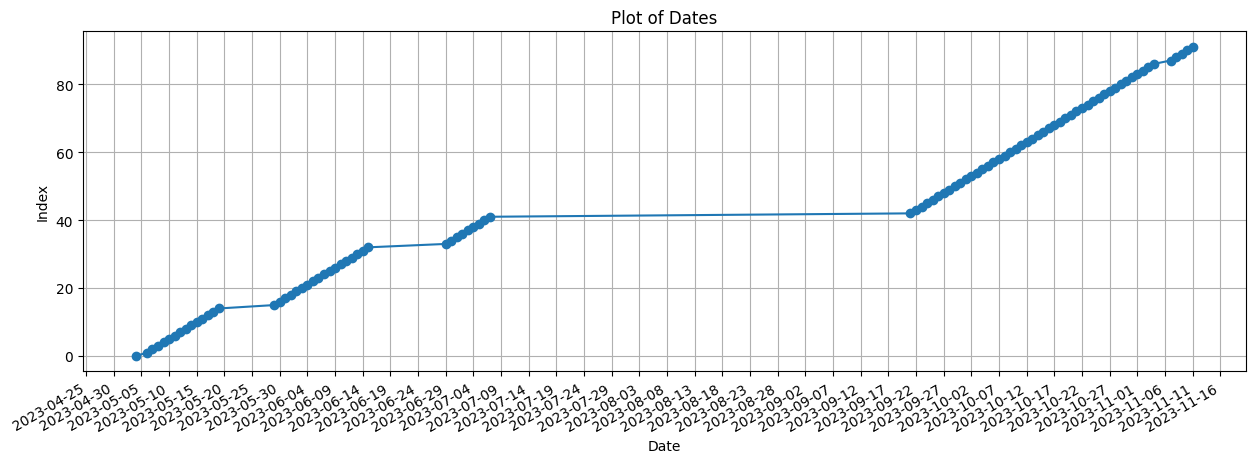

In [93]:
# Indices as y-values
indices = range(len(days))

# Creating the plot
plt.figure(figsize=(15, 5))
plt.plot(days, indices, marker='o', linestyle='-')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.gcf().autofmt_xdate() # Rotate date labels
plt.xlabel('Date')
plt.ylabel('Index')
plt.title('Plot of Dates')
plt.grid(True)
plt.show()

In [104]:
all_data.iloc[46535]

user_id                                      1
tracked_at    2023-10-03 07:06:40.046000+00:00
latitude                             50.865411
longitude                             4.244107
elevation                            86.300003
accuracy                                  20.0
geometry          POINT (4.2441068 50.8654105)
Name: 46541, dtype: object

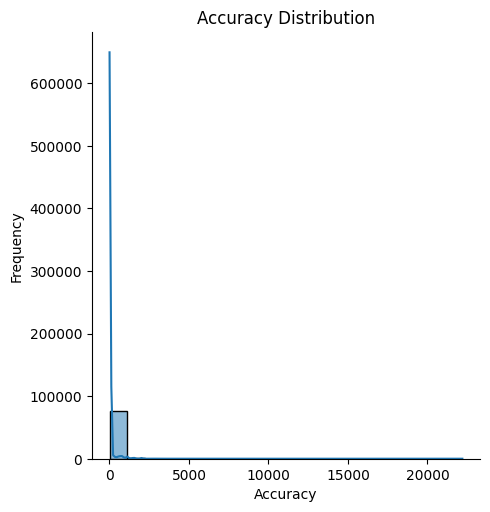

In [10]:
sns.displot(all_data['accuracy'], kde=True, bins=20)  # 'kde=True' adds the Kernel Density Estimate line

plt.title('Accuracy Distribution')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [11]:
all_data['accuracy'].describe()

count    77862.000000
mean        74.158133
std        413.088937
min          3.544000
25%         14.835000
50%         19.466499
75%         25.176500
max      22198.146484
Name: accuracy, dtype: float64

In [14]:
all_data[all_data['accuracy'] < 100]['accuracy'].count() / len(all_data)

0.9253936451670904